# K-means Clustering of 1 million headlines

reference: [K-means Clustering of 1 million headlines](https://www.kaggle.com/code/thebrownviking20/k-means-clustering-of-1-million-headlines/notebook)

## TODO
- `data vectorizing`的时候使用`ngram`策略。但是由于使用后可能会极大的增加训练速度，所以先使用`ngram=1`了解清楚完整流程，然后再进行这项耗时的步骤，防止因为考虑不完备而需要运行多次消耗时间。

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

# （可忽略）Practice

跟着reference练习一下使用方法。

## About the dataset

In [2]:
data_path = '/content/drive/MyDrive/A-Million-Headlines/input/abcnews-date-text.csv'
headline_col_name = 'headline_text'
data = pd.read_csv(data_path, 
                   on_bad_lines='warn', # warn instead of error when too many param in a row
                   usecols=[headline_col_name] # ignore the publish_date col
                   )
print(data.head())
print()
print(data.info())

                                       headline_text
0  aba decides against community broadcasting lic...
1     act fire witnesses must be aware of defamation
2     a g calls for infrastructure protection summit
3           air nz staff in aust strike for pay rise
4      air nz strike to affect australian travellers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1103665 entries, 0 to 1103664
Data columns (total 1 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   headline_text  1103665 non-null  object
dtypes: object(1)
memory usage: 8.4+ MB
None


## Deleting duplicate headline (if any)

In [3]:
data[
     data['headline_text'].duplicated(
         keep=False,  # Mark all duplicates as True
     ) 
    ].sort_values('headline_text')

,headline_text
57973,10 killed in pakistan bus crash
116304,10 killed in pakistan bus crash
912357,110 with barry nicholls
673104,110 with barry nicholls
676569,110 with barry nicholls
...,...
836312,zoo stoush heads to vcat
855864,zoonotic disease research
968356,zoonotic disease research
644443,zsa zsa back in hospital


In [4]:
# Drop duplicates except for the first occurrence
data = data.drop_duplicates('headline_text')
print(data.head())
print()
print(data.info())

                                       headline_text
0  aba decides against community broadcasting lic...
1     act fire witnesses must be aware of defamation
2     a g calls for infrastructure protection summit
3           air nz staff in aust strike for pay rise
4      air nz strike to affect australian travellers

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1076225 entries, 0 to 1103664
Data columns (total 1 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   headline_text  1076225 non-null  object
dtypes: object(1)
memory usage: 16.4+ MB
None


## NLP

Vectorize the data & using TF-IDF tool

----------------------------

值得注意的地方：

- 如果原文被特殊处理过，`stop-words`也需要经过相同的处理，否则可能部分失效。(如：*The word we’ve is split into we and ve by CountVectorizer’s default tokenizer, so if we’ve is in stop_words, but ve is not, ve will be retained from we’ve in transformed text. Our vectorizers will try to identify and warn about some kinds of inconsistencies.* See [reference](https://scikit-learn.org/stable/modules/feature_extraction.html#using-stop-words))

- 即使再周到的考虑，在未经实践前，也可能有疏漏之处。所以在实践时，及时检查处理得到的结果，从而发现并及时修改以提高模型表现。（如：查看词频结果，删除词频高但遗漏的低效词语；查看`stop-word list`，及时移除需要保留的词汇）

- sklearn使用和标准不同的`tf-idf`计算公式 $$IDF(t)=\log\frac{1+n}{1+df(t)}+1$$ 而非 $$IDF(t)=\log\frac{n}{df(t)}$$ 这是为了避免分母为0的情况，会导致计算出的idf值偏高，但这不会影响不同词之间的排序结果。See [refrence](https://towardsdatascience.com/how-sklearns-tf-idf-is-different-from-the-standard-tf-idf-275fa582e73d)


-------------------------

### Stop words
有较多的现成的停用词表可供选择，如

- `nltk.corpus.stopwords` (170 words)
- `sklearn.feature_extraction.text.ENGLISH_STOP_WORDS` (318 words)

这里使用`sklearn`的停用词库，，因为更全面。同时，把标点符号也去掉。

In [5]:
punc = list('.,"\'?!:;()[]{}%')
stop_words = text.ENGLISH_STOP_WORDS.union(punc)

### TfidfVectorizer

详细参数解释，见[document](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)
这里把

In [6]:
desc = data['headline_text'].values
vectorizer = TfidfVectorizer(
    input='content',                # default, {'filename', 'file', 'content'}
    encoding='utf-8',               # default, useful when files or bytes are given
    decode_error='strict',          # default, {'strict', 'ignore', 'replace'}
    strip_accents=None,             # default, {'ascii', 'unicode'}
    lowercase=True,                 # default
    preprocessor=None,              # default
    tokenizer=None,                 # default
    analyzer='word',                # default
    stop_words=stop_words,          # use customized stop words
    token_pattern=r"(?u)\b\w\w+\b", # default, regex for token, only used if analyzer=='word'
    ngram_range=(1,1),              # default
    max_df=1.0,                     # default
    min_df=1,                       # default
    max_features=None,              # default
    vocabulary=None,                # default, pre-provided vocabulary, can also be auto-created from input
    binary=False,                   # default
    # dtype=float64,                  # default, 'float64' need to be imported
    norm='l2',                      # default
    use_idf=True,                   # default, whether use idf(t)
    smooth_idf=True,                # default, if False, the “1” count is added to the idf instead of the idf’s denominator (see sklearn's tf-idf formula)
    sublinear_tf=False,             # default
    )
X = vectorizer.fit_transform(desc)

In [7]:
word_features = vectorizer.get_feature_names_out()
print(len(word_features))
print(word_features[5000:5100])

96397
['abyss' 'ac' 'aca' 'acacia' 'acacias' 'acadamy' 'academia' 'academic'
 'academics' 'academies' 'academy' 'academys' 'acai' 'acapulco' 'acars'
 'acason' 'acasuso' 'acb' 'acbf' 'acc' 'acca' 'accan' 'accc' 'acccc'
 'acccs' 'acccused' 'acce' 'accedes' 'accelerant' 'accelerants'
 'accelerate' 'accelerated' 'accelerates' 'accelerating' 'acceleration'
 'accelerator' 'accen' 'accent' 'accents' 'accentuate' 'accentuates'
 'accentuating' 'accenture' 'accept' 'acceptability' 'acceptable'
 'acceptably' 'acceptance' 'acceptances' 'accepted' 'accepting' 'acceptor'
 'acceptors' 'accepts' 'accerate' 'acces' 'access' 'accessary' 'accessed'
 'accesses' 'accessibility' 'accessible' 'accessing' 'accessories'
 'accessory' 'accesss' 'acci' 'accid' 'accide' 'acciden' 'accidenatlly'
 'accidenbt' 'accident' 'accidental' 'accidentally' 'accidently'
 'accidents' 'acciona' 'accis' 'acclaim' 'acclaimed' 'acclamation'
 'acclimatise' 'acco' 'accolade' 'accolades' 'accom' 'accomm' 'accommoda'
 'accommodate' 'a

### Stemming
将所有词转化为词根，从而简化处理难度
- `SnowballStemmer('english').stem(word)`函数。将返回`word`的词根


### Tokenizing
将句子打散为 词 + 标点符号
- `nltk.tokenize.RegexpTokenizer(regex).tokenize(sentence)`函数。将返回一个`token`组成的列表，`token`的样式由`regex`表达式决定，如：`[a-zA-Z\']+`将认为`he`，`dog's`，`Cat`都是一个`token`

[评论 @Sumeet Siddhartha](https://www.kaggle.com/code/thebrownviking20/k-means-clustering-of-1-million-headlines/comments)提到此处可以优化


```
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def tokenize(text):
    return [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text.lower())]
```

In [30]:
stemmer = SnowballStemmer('english') # choose language to use for SnowballStemmer
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [
        stemmer.stem(word) 
        for word in tokenizer.tokenize(text.lower())
    ]

# tokenized_stop_words = []
# for word in stop_words:
#     tokens = tokenizer.tokenize(word.lower())
#     for token in tokens:
#         tokenized_stop_words.append(stemmer.stem(token))
tokenized_stop_words = tokenize(' '.join(stop_words))

In [25]:
vectorizer2 = TfidfVectorizer(
    stop_words=tokenized_stop_words,
    tokenizer=tokenize, # use customized tokenizer (func `tokenize`)
)
X2 = vectorizer2.fit_transform(desc)
word_features2 = vectorizer2.get_feature_names_out()
print(len(word_features2))
print(word_features2[:50])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['anywh', 'el', 'elsewh', 'everywh', 'ind', 'otherwi', 'plea', 'somewh'] not in stop_words.
  % sorted(inconsistent)


65173
["'a" "'i" "'s" "'t" 'aa' 'aaa' 'aaahhh' 'aac' 'aacc' 'aaco' 'aacta' 'aad'
 'aadmi' 'aag' 'aagaard' 'aagard' 'aah' 'aalto' 'aam' 'aamer' 'aami'
 'aamodt' 'aandahl' 'aant' 'aap' 'aapa' 'aapt' 'aar' 'aaradhna' 'aardman'
 'aardvark' 'aargau' 'aaron' 'aaronpaul' 'aarwun' 'aat' 'ab' 'aba'
 'abaaoud' 'ababa' 'aback' 'abadi' 'abadon' 'abal' 'abalon' 'abalonv'
 'abama' 'abandon' 'abandond' 'abandong']


### max_features=1000
[评论 @Steve Tan](https://www.kaggle.com/code/thebrownviking20/k-means-clustering-of-1-million-headlines/comments)提到此处使用`max_features`

```
vectorizer3 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 1000)
```
可以提高分数
```
from sklearn.metrics import silhouette_score
silhouette_score(X3, labels=kmeans.predict(X3))
```



In [35]:
vectorizer3 = TfidfVectorizer(
    stop_words=tokenized_stop_words,
    tokenizer=tokenize,
    max_features=1000,
)
X3 = vectorizer3.fit_transform(desc)
word_features3 = vectorizer3.get_feature_names_out()
print(len(word_features3))
print(word_features3[:50])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['anywh', 'el', 'elsewh', 'everywh', 'ind', 'otherwi', 'plea', 'somewh'] not in stop_words.
  % sorted(inconsistent)


1000
['abbott' 'abc' 'aborigin' 'abus' 'access' 'accid' 'accus' 'act' 'action'
 'ad' 'address' 'adelaid' 'admit' 'affect' 'afghan' 'afghanistan' 'afl'
 'africa' 'age' 'agre' 'agreement' 'ahead' 'aid' 'aim' 'air' 'airport'
 'al' 'alcohol' 'alert' 'alic' 'alleg' 'allow' 'alp' 'ambul' 'amid'
 'andrew' 'anger' 'anim' 'announc' 'anti' 'anzac' 'appeal' 'appear'
 'appoint' 'approv' 'area' 'arm' 'armi' 'arrest' 'arriv']


## K-means clustering

### Elbow method

使用“肘部法则”选择合适的`k`值。

100%|██████████| 14/14 [10:22<00:00, 44.44s/it]


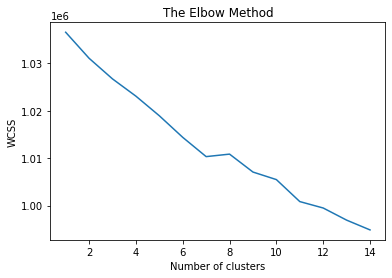

In [36]:
from sklearn.cluster import KMeans
from tqdm import tqdm

wcss = []
for i in tqdm(range(1,15)):
    kmeans = KMeans(
        n_clusters=i,       # applying elbow strategy
        init='k-means++',   # default
        n_init=10,          # default
        max_iter=300,       # default
        tol=0.0001,         # default
        verbose=0,          # default
        random_state=0,     # determine random number generation for centroid initialization.
        copy_x=True,        # default
        algorithm='auto',   # default
        )
    kmeans.fit(X3)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,15), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.show()

### Start clustering

### 7 clusters

In [42]:
kmeans7 = KMeans(
    n_clusters=7,  # cluter number
    n_init=20,      # number of interations for clustering
)
kmeans7.fit(X3)

# cluster_centers_: ndarray (shape=(7, 1000))
# [:, -1:-26:-1]: print first 25 words
common_words = kmeans7.cluster_centers_.argsort()[:, -1:-26:-1]

for num, centroid in enumerate(common_words):
    print(
        str(num)+
        ' : '+
        ', '.join(word_features3[word] for word in centroid))

0 : new, win, council, australia, govt, court, report, charg, kill, warn, australian, urg, fund, face, open, water, nsw, death, crash, year, claim, chang, wa, sydney, attack
1 : polic, investig, probe, offic, search, hunt, death, car, arrest, drug, miss, shoot, seek, charg, driver, crash, attack, murder, assault, suspect, fatal, raid, warn, station, woman
2 : say, polic, need, govt, minist, mp, expert, union, council, australia, report, labor, group, wont, opposit, govern, new, public, pm, chang, time, health, wa, chief, mayor
3 : interview, extend, nrl, michael, afl, john, speak, david, mark, smith, andrew, jame, peter, scott, polic, toni, william, minist, cricket, ceo, brown, jone, author, clark, abc
4 : plan, council, govt, new, water, develop, say, hous, group, chang, unveil, reject, park, urg, centr, public, expans, green, resid, health, reveal, govern, labor, opposit, power
5 : qld, miss, search, rural, north, central, govt, podcast, woman, health, flood, continu, govern, new, ho

In [43]:
joblib.dump(kmeans7, 'k_means_headlines_7_cluster_model.pkl')

['k_means_headlines_7_cluster_model']

### 10 clusters

看图发现10那里拐点最明显

In [37]:
kmeans10 = KMeans(
    n_clusters=10,  # cluter number
    n_init=20,      # number of interations for clustering
)
kmeans10.fit(X3)

# cluster_centers_: ndarray (shape=(10, 1000))
# [:, -1:-26:-1]: print first 25 words
common_words = kmeans10.cluster_centers_.argsort()[:, -1:-26:-1]

for num, centroid in enumerate(common_words):
    print(
        str(num)+
        ' : '+
        ', '.join(word_features3[word] for word in centroid))

0 : say, plan, report, water, need, chang, group, public, minist, rural, govern, health, resid, urg, mp, releas, labor, restrict, green, cut, opposit, australia, farmer, murray, mayor
1 : polic, interview, investig, probe, man, search, offic, hunt, miss, arrest, car, death, shoot, drug, seek, attack, assault, crash, murder, charg, driver, say, suspect, fatal, raid
2 : win, award, cup, titl, open, gold, stage, world, final, tour, australia, lead, seri, aussi, claim, second, australian, big, grand, england, m, battl, race, record, sydney
3 : sa, make, indigen, rural, health, countri, communiti, hour, chang, plan, fund, job, govern, land, say, boost, leader, group, histori, return, report, urg, start, art, hous
4 : new, council, plan, zealand, consid, law, fund, year, centr, seek, water, rate, urg, open, develop, look, hope, land, mayor, push, deal, hospit, home, set, park
5 : week, pacif, speak, highway, beat, island, ban, market, end, nation, miss, face, forum, share, worker, australia,

## save & load model & festures

[reference](https://cloud.tencent.com/developer/article/1692491)

In [38]:
import joblib

### save model

In [39]:
joblib.dump(kmeans7, "k_means_headlines_7_cluster_model.pkl")
joblib.dump(kmeans10, "k_means_headlines_10_cluster_model.pkl")
joblib.dump(word_features3, 'k_means_headlines_1000_max_feature_names.pkl')

['k_means_headlines_10_cluster_feature_names.pkl']

### load model

In [41]:
loaded_kmeans7_model = joblib.load("k_means_headlines_7_cluster_model.pkl")
loaded_kmeans10_model = joblib.load("k_means_headlines_10_cluster_model.pkl")
loaded_kmeans_feature_names = joblib.load('k_means_headlines_1000_max_feature_names.pkl')

# （真正内容）Application: News Recommandation

目标：
- 输入：一个用户正在读的新闻的标题，一堆用户未来可能读的新闻的标题
- 输出：按照用户未来阅读可能性排序的新闻标题

## （可忽略）热身

### check our loaded model and feature names

In [112]:
classified_words = loaded_kmeans_model.cluster_centers_.argsort()[:, ::-1]

for num, centroid in enumerate(classified_words):
    print(
        str(num)+
        ' : '+
        ', '.join(loaded_kmeans_feature_names[word] for word in centroid))

0 : new, plan, council, govt, urg, water, consid, law, zealand, develop, centr, nsw, qld, chang, hous, hospit, reject, year, seek, group, m, park, health, wa, boost, mayor, rate, open, push, sa, land, announc, local, defend, support, green, elect, welcom, unveil, servic, meet, help, act, school, set, power, concern, indigen, approv, minist, hope, deal, region, look, offer, work, vic, job, merger, opposit, cut, home, manag, public, nt, industri, shire, want, accus, reveal, labor, nation, vote, review, rule, port, resid, fear, farm, rise, face, secur, communiti, site, rail, cost, coast, tourism, busi, attack, budget, delay, launch, appoint, releas, road, worker, fight, mp, build, scheme, question, protect, decis, promis, ceo, citi, light, south, air, pm, chief, criticis, govern, airport, plant, talk, state, expans, feder, pay, propos, protest, sign, ahead, union, test, tax, sale, murray, high, polici, station, project, tas, farmer, fed, train, need, action, flood, deni, make, sydney, sav

In [81]:
np.shape(classified_words)

(10, 1000)

### Tokenizer

We first need to tokenize every headline (from input) in order to use the model

In [75]:
stemmer = SnowballStemmer('english') # choose language to use for SnowballStemmer
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [
        stemmer.stem(word) 
        for word in tokenizer.tokenize(text.lower())
    ]

### Score each headline on each class

get the scores of each headline belongs to which topic



In [97]:
lines = [
         'Ukraine war: Mariupol ultimatum passes as hundreds shelter in steel mill',
         'Hepatitis cases detected in children in Europe and the US',
         'Climate change, albinism and me',
         'Netflix hints at password sharing crackdown as subscribers fall',
]
all_line_scores = []
for line in lines:
    tokenized_line = tokenize(line)
    scores = [0 for _ in range(len(classified_words))]
    for word in tokenized_line: # for each tokenized word in our line
        for i in range(len(classified_words)): # in each class of tokens
            classfied_word_len = len(classified_words[i])
            for j in range(classfied_word_len): # for each token in the class
                classified_word = classified_words[i][j]
                if word == loaded_kmeans_feature_names[classified_word]:
                    scores[i] += classfied_word_len - j
    all_line_scores.append(scores)
all_line_scores

[[1312, 1389, 1437, 1454, 1136, 986, 1412, 1197, 1336, 1220],
 [1429, 1648, 1521, 1646, 1795, 1733, 1666, 1282, 1667, 1650],
 [1660, 1601, 1616, 743, 1899, 733, 841, 1870, 1811, 1900],
 [1403, 1930, 1974, 1387, 1482, 1385, 1758, 1850, 1208, 2345]]

In [100]:
np.argmax(all_line_scores, axis=1)

array([3, 4, 9, 9])

### Get the class of each headline in possibility-decreased-order

In [111]:
np.argsort(all_line_scores, axis=1)[:, ::-1]

array([[3, 2, 6, 1, 8, 0, 9, 7, 4, 5],
       [4, 5, 8, 6, 9, 1, 3, 2, 0, 7],
       [9, 4, 7, 8, 0, 2, 1, 6, 3, 5],
       [9, 2, 1, 7, 6, 4, 0, 3, 5, 8]])

## （真正内容）正式开始

### Build the application

In [69]:
class HeadlineRecommender:
    
    def __init__(self, model_path:str, feature_path:str):
        self.stemmer = SnowballStemmer('english') # choose language to use for SnowballStemmer
        self.tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')
        self.model = joblib.load(model_path)
        self.feature_names = joblib.load(feature_path)
        
    def __tokenize(self, text):
        return [
            self.stemmer.stem(word) 
            for word in self.tokenizer.tokenize(text.lower())
        ]

    def __classify_one_line(self, line:str, all_ranked_feature_idx:list)->list:
        '''Return the scores of the line in each class. The class with higher score has lower index.'''
        tokenized_line = self.__tokenize(line)
        scores = [0 for _ in range(len(all_ranked_feature_idx))]
        for word in tokenized_line: # for each tokenized word in the headline
            for i in range(len(all_ranked_feature_idx)): # in each class of token group
                one_cluster_ranked_feature_idx = all_ranked_feature_idx[i]
                one_cluster_feature_num = len(one_cluster_ranked_feature_idx)
                for j in range(one_cluster_feature_num): # for each token in the class
                    if word == loaded_kmeans_feature_names[one_cluster_ranked_feature_idx[j]]:
                        scores[i] += one_cluster_feature_num - j
        # scores example:
        #   [[1312, 1389, 1437, 1454, 1136, 986, 1412, 1197, 1336, 1220],
        #    [1429, 1648, 1521, 1646, 1795, 1733, 1666, 1282, 1667, 1650],
        #    [1660, 1601, 1616, 743, 1899, 733, 841, 1870, 1811, 1900],
        #    [1403, 1930, 1974, 1387, 1482, 1385, 1758, 1850, 1208, 2345]]

        # return example:
        #   array([[3, 2, 6, 1, 8, 0, 9, 7, 4, 5],
        #          [4, 5, 8, 6, 9, 1, 3, 2, 0, 7],
        #          [9, 4, 7, 8, 0, 2, 1, 6, 3, 5],
        #          [9, 2, 1, 7, 6, 4, 0, 3, 5, 8]])
        return np.argsort(scores)[::-1]

    def __gen_weights(self, arr_len:int)->list:
        '''
        Assign weights to each element in an 1darray with length `arr_len`. 
        @return the weights list. Example: [4.0, 3.5, 3.3333333333333335, 3.25, 3.2, 3.1666666666666665, 3.142857142857143]
        '''
        def f(x, k, b):
            return k/(k+x)+b
        return [f(x, int(arr_len/5), int(arr_len/2)) for x in range(arr_len)]

    def predict(self, curr_headline:str, future_headlines:list):
        '''
        Predict the relativity of future headlines with current headline.
        @return ranked list of future headlines. headline with higher relation with current headline has smaller index in the list.
        '''

        # all_ranked_feature_idx example:
        #   array([[582, 978, 210, ..., 644, 632, 681],
        #          [644, 464, 663, ..., 885, 961, 589],
        #          [765, 644, 581, ..., 391, 992, 934],
        #          ...,
        #          [632, 210, 388, ..., 642, 160, 125],
        #          [681, 566, 772, ..., 391, 286, 376],
        #          [542, 159, 475, ..., 776, 465, 132]])
        all_ranked_feature_idx = self.model.cluster_centers_.argsort()[:, ::-1]

        # curr_line_category_rank example:
        #   array([3, 2, 6, 1, 8, 0, 9, 7, 4, 5])
        curr_line_category_rank = self.__classify_one_line(curr_headline, all_ranked_feature_idx)

        # all_line_category_rank example:
        #   array([[3, 2, 6, 1, 8, 0, 9, 7, 4, 5],
        #          [4, 5, 8, 6, 9, 1, 3, 2, 0, 7],
        #          [9, 4, 7, 8, 0, 2, 1, 6, 3, 5],
        #          [9, 2, 1, 7, 6, 4, 0, 3, 5, 8]])
        all_line_category_rank = [] # category rank of curr_headline and future_headlines
        for line in future_headlines:
            all_line_category_rank.append(self.__classify_one_line(line, all_ranked_feature_idx))
        
        # tgt rank: [1,2,3]
        #            ^ ^ ^
        # weights -> 3 2 1
        # --------------------
        # candidates | score
        #  [1,3,2]     9+2+2=13
        #  [2,1,3]     6+6+1=13
        #  [2,3,1]     6+2+3=11
        #  [3,1,2]     3+6+2=11
        #  [3,2,1]     3+4+3=10
        #   ^ ^ ^
        #   3 2 1  <- weights
        all_scores = [0 for _ in range(len(all_line_category_rank))]
        weights = self.__gen_weights(len(curr_line_category_rank))
        
        for i in range(len(all_line_category_rank)):
            one_rank = all_line_category_rank[i]  # array([4, 5, 8, 6, 9, 1, 3, 2, 0, 7])
            for j in range(len(one_rank)):
                category, category_w = one_rank[j], weights[j] # 4, 6.3
                for k in range(len(curr_line_category_rank)):  # array([3, 2, 6, 1, 8, 0, 9, 7, 4, 5])
                    if category == curr_line_category_rank[k]:
                        # all_scores example:
                        #   [79.235, 79.516, 79.515, 79.370, 79.359, 79.946, 79.380, 79.369, 79.952, 79.469, 80.00, 79.499, 79.293]
                        all_scores[i] += category_w * weights[k]

        # print([int(s*100)/100 for s in all_scores])
        # print(np.argsort(all_scores)[::-1])
        ranked_future_headlines_idx = np.argsort(all_scores)[::-1]
        ranked_future_headlines = [future_headlines[idx] for idx in ranked_future_headlines_idx]
        return ranked_future_headlines


### Use the application

使用方法：
- 准备`joblib`格式保存的 模型 和 `feature_names` 的文件，将文件路径传入`HeadlineRecommender`实例
- 准备新闻标题数据集
- 传入一个标题字符串，和一个被预测的标题组成的列表，使用`predict`方法开始预测
- 返回：一个按照和当前标题相关度排序的标题列表

In [50]:
headline_database = [
             "Anguish for thousands trapped in Mariupol as evacuation stalls",
             "Moscow has deported 500,000 to Russia, says Ukrainian politician",
             "Ukraine war: Holocaust survivor aged 91 among Mariupol's civilian dead - reports",
             "Shark Tank: India TV show proves entrepreneurship isn't just for rich",
             "Afghan refugees 'still stranded' in NI hotels",
             "Measles outbreak sweeps through Liberia",
             "Australia election: PM Morrison's security team in car crash in Tasmania",
             "Australia's koalas: Freeze sperm to save species, say researchers",
             "Andrew McDonald named coach of Australia's men's cricket team",
             "China gains a foothold in Australia's backyard",
             "Damaris Muthee Mutua: Kenya police launch manhunt after athlete killed",
             "Why Koreans could soon become a year younger",
             "Wayne Quilliam: Photographing the diversity of Aboriginal Australia",
             "Irish Travellers say racism is causing a suicide crisis",
]

curr_headline = headline_database[0]
potencial_headlines = headline_database[1:]

In [71]:
hr = HeadlineRecommender(
    '/content/k_means_headlines_10_cluster_model.pkl',
    '/content/k_means_headlines_1000_max_feature_names.pkl',
)
hr.predict(curr_headline, potencial_headlines)

['Damaris Muthee Mutua: Kenya police launch manhunt after athlete killed',
 'Measles outbreak sweeps through Liberia',
 "Australia election: PM Morrison's security team in car crash in Tasmania",
 "Afghan refugees 'still stranded' in NI hotels",
 'Irish Travellers say racism is causing a suicide crisis',
 'Why Koreans could soon become a year younger',
 "Ukraine war: Holocaust survivor aged 91 among Mariupol's civilian dead - reports",
 "Shark Tank: India TV show proves entrepreneurship isn't just for rich",
 'Wayne Quilliam: Photographing the diversity of Aboriginal Australia',
 'Moscow has deported 500,000 to Russia, says Ukrainian politician',
 "Australia's koalas: Freeze sperm to save species, say researchers",
 "China gains a foothold in Australia's backyard",
 "Andrew McDonald named coach of Australia's men's cricket team"]